# Project 5

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import decomposition

from jupyterthemes import jtplot
jtplot.style(theme="chesterish")


dfpop=pd.read_csv('FAOSTAT_pop2012_2013.csv')
dfdispo_alim=pd.read_csv('FAOSTAT_dispo_alim.csv')

In [23]:
#table avec les populations, comparaison entre 2012 et 2013
dfpop=dfpop[['Pays','Produit','Année','Valeur']]
dfpop_piv=dfpop.pivot_table(index=['Pays'],columns=['Année'],values=['Valeur'],aggfunc=sum)
dfpop_piv.columns=[2012,2013]
dfpop_piv=dfpop_piv.reset_index()
dfpop_piv['Variation_pop']=((dfpop_piv[2013]-dfpop_piv[2012])/dfpop_piv[2012])*100

In [24]:
#Chiffres de l'année 2013

#table dans laquelle on isole la dispo alim totale et d'origine animale
dfdispo_alim=dfdispo_alim[['Pays','Élément','Produit','Valeur']]
dfdispo_alim=dfdispo_alim.loc[(dfdispo_alim['Élément']!='Disponibilité alimentaire (Kcal/personne/jour)') | (dfdispo_alim['Produit']!='Produits Animaux')]

#table avec les disponibilités alimentaire en calories seulement
dfdispo_cal=dfdispo_alim.loc[dfdispo_alim['Élément']=='Disponibilité alimentaire (Kcal/personne/jour)']
dfdispo_cal['Dispo_alim_kcal_hab_an']=dfdispo_cal['Valeur']*365

#on enlève donc les valeurs de la table dfdispo_cal
dfdispo_alim=dfdispo_alim.loc[dfdispo_alim['Élément']!='Disponibilité alimentaire (Kcal/personne/jour)']

#table qui nous permet de calculer la prop de prot d'origine animale
dfprot_anim=dfdispo_alim.pivot_table(index=['Pays',],columns=['Produit'],values=['Valeur'],aggfunc=sum)
dfprot_anim.columns=['Produits Animaux','Total General']
dfprot_anim=dfprot_anim.reset_index()
dfprot_anim['prop_prot_animale']=dfprot_anim['Produits Animaux']/dfprot_anim['Total General']
dfprot_anim['Dispo_alim_prot_hab_an']=dfprot_anim['Total General']*365

/Users/Lamazere/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [25]:
df=pd.merge((pd.merge((pd.merge(dfpop_piv[['Pays','Variation_pop']],dfprot_anim[['Pays','prop_prot_animale']],on='Pays',how='left')),
         dfprot_anim[['Pays','Dispo_alim_prot_hab_an']],on='Pays',how='left')),
         dfdispo_cal[['Pays','Dispo_alim_kcal_hab_an']],on='Pays',how='left')

df.set_index('Pays',inplace=True)
df.head()


,Variation_pop,prop_prot_animale,Dispo_alim_prot_hab_an,Dispo_alim_kcal_hab_an
Pays,,,,
Afghanistan,2.437552,0.209785,21261.25,762850.0
Afrique du Sud,0.744474,0.426345,31145.45,1103030.0
Albanie,0.347881,0.533297,40668.30,1165445.0
Algérie,1.886596,0.271749,33565.40,1203040.0
Allemagne,-0.088164,0.605178,37080.35,1277135.0


In [26]:
df.describe()

,Variation_pop,prop_prot_animale,Dispo_alim_prot_hab_an,Dispo_alim_kcal_hab_an
count,174.000000,174.000000,174.000000,1.740000e+02
mean,1.330757,0.427343,29698.728448,1.039862e+06
std,1.240906,0.161308,7296.216418,1.599148e+05
min,-0.768355,0.098398,13745.900000,6.858350e+05
25%,0.430648,0.285553,23503.262500,9.239975e+05
50%,1.200912,0.450749,29782.175000,1.034045e+06
75%,2.014859,0.564288,34657.662500,1.164168e+06
max,9.595655,0.730841,48742.100000,1.375320e+06


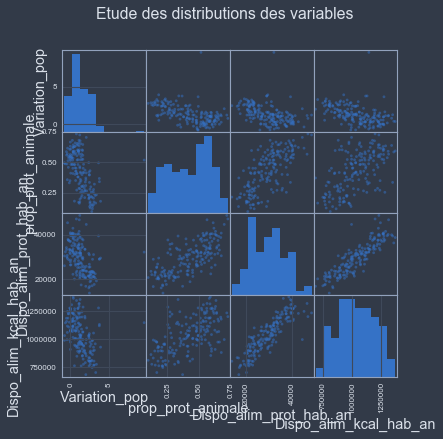

In [27]:
from pandas.plotting import scatter_matrix

scatter_matrix(df,figsize=(6,6))
plt.suptitle('Etude des distributions des variables')
plt.savefig('Etude des distributions des variables')
plt.show()

In [28]:
df.corr()

,Variation_pop,prop_prot_animale,Dispo_alim_prot_hab_an,Dispo_alim_kcal_hab_an
Variation_pop,1.000000,-0.504595,-0.429638,-0.425278
prop_prot_animale,-0.504595,1.000000,0.705906,0.587596
Dispo_alim_prot_hab_an,-0.429638,0.705906,1.000000,0.875731
Dispo_alim_kcal_hab_an,-0.425278,0.587596,0.875731,1.000000


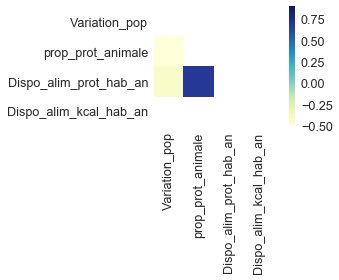

In [9]:
mask = np.zeros_like(df.corr().abs())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(df.corr(),mask=mask, vmax=.9, square=True,cmap="YlGnBu")
 
plt.tight_layout()
plt.savefig('Heatmap des corrélations')

__Classification hiérarchique avec la méthode de Ward__

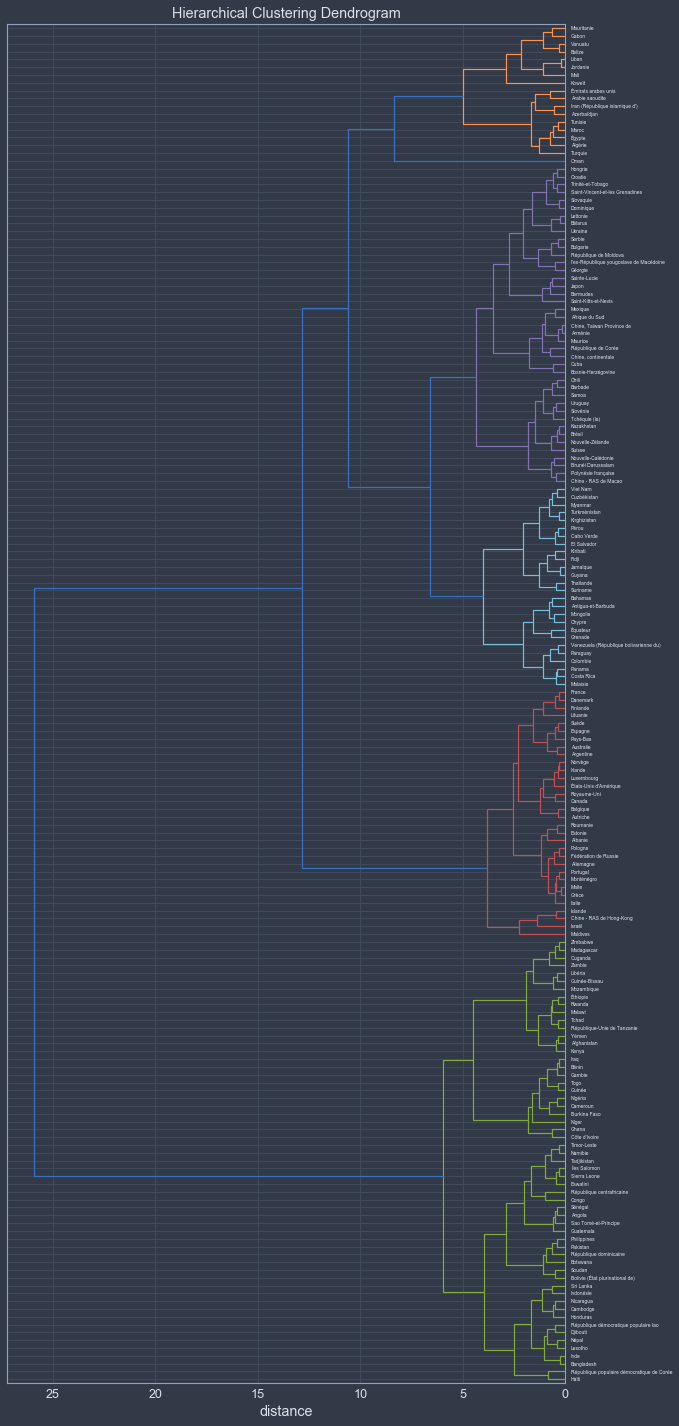

In [29]:
from functions import plot_dendrogram

# préparation des données 
X = df.values
names = df.index
features=df.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names,6)

Nous avons ci-dessus séparé en 6 clusters(en réalité 5, car le pays "Oman" est seul dans son cluster) , mais regardons s'il y a un nombre meilleur de partitionnement.

Regardons la qualité du clustering en fonction de k grâce à la métrique silhouette, qui pour chaque observation i, définit $a(i)$ comme la distance du point à son centroïd et $b(i)$ comme la distance de ce point à la plus petite distance moyenne du cluster voisin, la silhouette métrique se définit donc par:

$$\frac{b(i)-a(i)}{max(b(i),a(i))}$$

La meilleure valeure est 1 bien évidemment, le meilleur résultat ici est pour k=2.

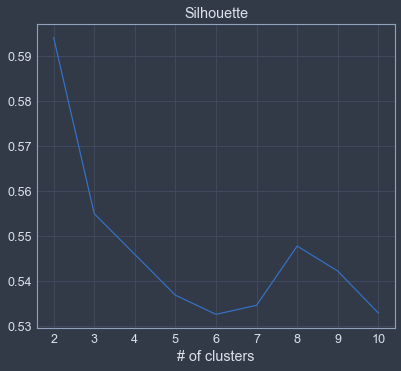

In [30]:
from sklearn import cluster, metrics
res= np.arange(9,dtype="double")
for k in np.arange(9):
    kmm = cluster.KMeans(n_clusters=k+2)
    kmm.fit(X)
    res[k] = metrics.silhouette_score(X,kmm.labels_)

plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.savefig("Silhouette")
plt.show()

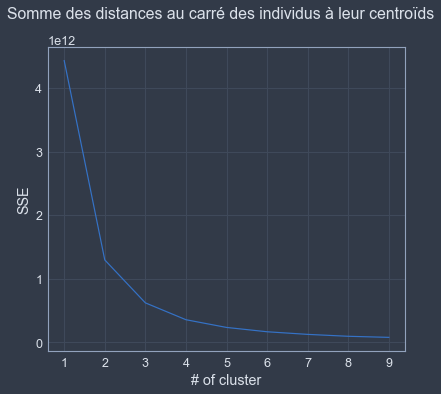

In [33]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("# of cluster")
plt.ylabel("SSE")
plt.suptitle("Somme des distances au carré des individus à leur centroïds")
plt.savefig("Somme des distances au carré des individus à leur centroïds")
plt.show()

In [34]:
# Coupage du dendrogramme en 5 clusters
clusters_ward = fcluster(Z, 5, criterion='maxclust')
#affichage des observations et leurs groupes
idg= np.argsort(clusters_ward)
df_clusters_CAH=pd.DataFrame(df.index[idg],clusters_ward[idg])
 
df_clusters_CAH.to_csv("clusters_CAH.csv")

__Partitionnement des individus par l'algorithme du k-means__

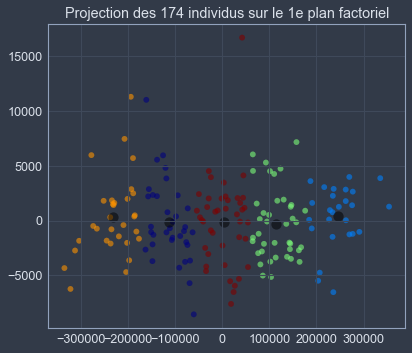

In [35]:
# Nombre de clusters souhaités
n_clust = 5

# choix du nombre de composantes à calculer
n_comp = 4

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters_kmeans = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=n_comp).fit(X) #calcul des composantes principales avec une ACP
X_projected = pca.transform(X) #projection des individus (table dim(174,4) avec 4 composantes)

plt.scatter(X_projected[:, 0], X_projected[:, 1],
            c=clusters_kmeans.astype(np.float), cmap = 'jet',
            alpha=.6) #1er plan factoriel

#projection des centres
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids) #projection des centroïdes
plt.scatter(centroids_projected[:,0],centroids_projected[:,1],c='black', s=100, alpha=0.5)

plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))

plt.show()

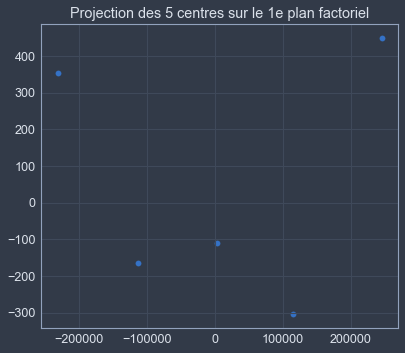

In [36]:
# Affichage plus précis des positions des centres de classes
plt.figure()

plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.savefig("Projection des 5 centres sur le 1e plan factoriel")
plt.show()

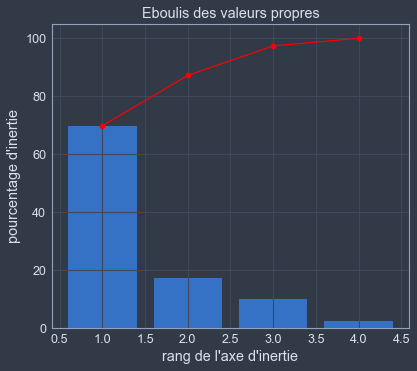

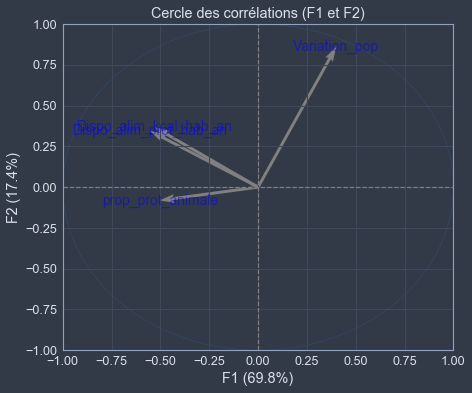

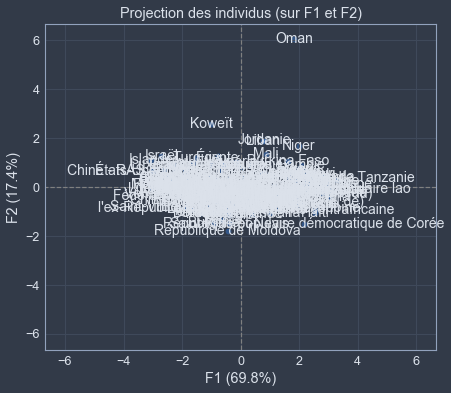

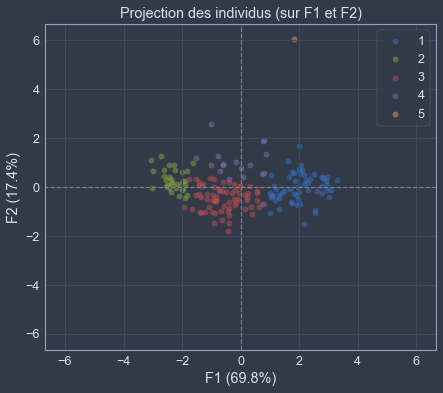

In [37]:
from functions import display_scree_plot,display_circles, display_factorial_planes

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)],labels = np.array(features))

# Projection des individus 
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],
                          labels = np.array(names), alpha = 0.5)

# Projection des individus visionnables par clusters établis avec 
#le clustering hiérarchique selon la méthode de Ward 
#càd par minimisation variance intraclasse à chaque regroupement de cluster
#d'ailleurs on remarque que la partition apparait mieux qu'avec le kmeans
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],
                         illustrative_var = clusters_ward, alpha = 0.5)

plt.show()

87% de la variance est expliquée avec les deux premières composantes

In [38]:
pcs[0]

array([ 0.39984608, -0.50373961, -0.55283475, -0.52985211])

F1=0.39*Variation_pop - 0.5prop_prot_animale -0.55dispo_prot-0.52dispo_kcal

In [39]:
#contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1) 
pd.DataFrame({'ID':df.index,'d_i':di}).sort_values('d_i',ascending=False).head()

,ID,d_i
112,Oman,45.505157
73,Islande,11.703417
165,Zambie,11.286588
33,Chine - RAS de Hong-Kong,10.529776
88,Lituanie,9.599013


In [40]:
#qualité de représentation des individus - COS2
cos2 = X_projected**2
for j in range(df.shape[1]):
    cos2[:,j] = cos2[:,j]/di 

pd.DataFrame({'id':df.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}).head()

,id,COS2_1,COS2_2
0,Afghanistan,0.967209,0.003569
1,Afrique du Sud,0.608518,0.088400
2,Albanie,0.912225,0.001289
3,Algérie,0.011593,0.425480
4,Allemagne,0.967353,0.005627


In [42]:
from math import cos

#vérifions la théorie - somme en ligne des cos2 = 1
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [43]:
#contributions aux axes
n=df.shape[0]
eigval=(n-1)/n*pca.explained_variance_

ctr = X_projected**2 #X_projected représente les coordonnées factorielles
for j in range(df.shape[1]):
    ctr[:,j] = ctr[:,j]/(n*eigval[j])
pd.DataFrame({'id':df.index,'CTR_1':ctr[:,0],
                    'CTR_2':ctr[:,1]})[['id','CTR_2']].sort_values('CTR_2',
                                                                   ascending=False).head(5)


,id,CTR_2
112,Oman,0.304538
83,Koweït,0.055897
78,Jordanie,0.030750
86,Liban,0.029164
129,République de Moldova,0.026175


Soit $C_{i}^{k}$
la kième composante principale pour le ième individu. 

$\lambda ^{k}$ représente l'inertie portée par l'axe de rang k.

$$\sum_{i=1}^{n}\frac{(C_{i}^{k})^2}{n} = \lambda ^{k}$$

La contribution de l’individu Ei à la composante k est donc définie par 

$$\frac{\frac{(C_{i}^{k})^2}{n}}{\lambda^{k}}$$

In [44]:
#pour visualiser quels sont les meilleurs par variables...
for i in range(0,4):
    print(10*'-')
    print((df.sort_values(df.dtypes.index[i],ascending=False).head(3)).iloc[:,i])

----------
Pays
Oman        9.595655
Niger       3.928426
Jordanie    3.780853
Name: Variation_pop, dtype: float64
----------
Pays
Chine - RAS de Hong-Kong    0.730841
Islande                     0.722480
Maldives                    0.702115
Name: prop_prot_animale, dtype: float64
----------
Pays
Islande                     48742.1
Chine - RAS de Hong-Kong    47150.7
Israël                      46771.1
Name: Dispo_alim_prot_hab_an, dtype: float64
----------
Pays
Autriche    1375320.0
Belgique    1362545.0
Turquie     1352690.0
Name: Dispo_alim_kcal_hab_an, dtype: float64


Centrons désormais notre analyse sur deux clusters puis choisissons les meilleurs pays dans chacun. Analyse du premier plan factoriel issu de l'ACP: le 1er axe d'inertie maximale correspond à la richesse alimentaire dans le pays, le second à la croissance démographique dans le pays. Ainsi, plus le pays se situe sur la droite et moins les habitants du pays "mangent à leur faim", et plus l'individu se situe haut et plus le nombre d'habitants augmente d'année en année.
On choisit ainsi de prendre le groupe qui a la plus grande richesse alimentaire (car potentiellement les habitants sont habitués à un régime alimentaire conséquent), __le groupe 2, les pays riches en somme__  et un autre qui a une position intermédiaire selon l'étude des deux axes d'inerties maximum, __le groupe 4__. Effectuons désormais des analyses plus poussés sur ces deux clusters choisis avec le clustering hiérarchique.

Vérifions à quel cluster appartient notre centroid en calculant les moyennes de chaque variable dans les clusters.

In [45]:
idg_km= np.argsort(km.labels_)
df_clusters_kmeans=pd.DataFrame(df.index[idg_km],km.labels_[idg_km])

for i in range(5):
    print(20*"-")
    print('cluster',i)
    print((pd.merge(df_clusters_kmeans[df_clusters_kmeans.index==i],df,
                    on='Pays',how='left')).mean())


--------------------
cluster 0
Variation_pop             1.056716e+00
prop_prot_animale         4.994443e-01
Dispo_alim_prot_hab_an    3.403093e+04
Dispo_alim_kcal_hab_an    1.152347e+06
dtype: float64
--------------------
cluster 1
Variation_pop                  2.282213
prop_prot_animale              0.270163
Dispo_alim_prot_hab_an     20322.778846
Dispo_alim_kcal_hab_an    794057.500000
dtype: float64
--------------------
cluster 2
Variation_pop                  1.748378
prop_prot_animale              0.350043
Dispo_alim_prot_hab_an     24833.413750
Dispo_alim_kcal_hab_an    925786.000000
dtype: float64
--------------------
cluster 3
Variation_pop             6.531977e-01
prop_prot_animale         5.344975e-01
Dispo_alim_prot_hab_an    3.929578e+04
Dispo_alim_kcal_hab_an    1.271118e+06
dtype: float64
--------------------
cluster 4
Variation_pop             1.072499e+00
prop_prot_animale         4.590912e-01
Dispo_alim_prot_hab_an    2.944281e+04
Dispo_alim_kcal_hab_an    1.036244e+

In [46]:
#récupération des centroids (issus du Kmeans) sous forme de dataframe
df_centroids=pd.DataFrame(centroids,
                          index=['Centre 4','Centre 3','Centre 1','Centre 0','Centre 2'],
                          columns=df.columns)

df_centroids.sort_index().to_csv("centroids_kmeans.csv")
df_centroids.sort_index(inplace=True)

#normalized data
df_centroids_norma=(df_centroids-df_centroids.mean())/df_centroids.std()
df_centroids_norma=df_centroids_norma.reset_index()
df_centroids_norma

,index,Variation_pop,prop_prot_animale,Dispo_alim_prot_hab_an,Dispo_alim_kcal_hab_an
0,Centre 0,-1.096105,1.018297,1.302145,1.259488
1,Centre 1,0.596069,-0.661008,-0.637182,-0.589693
2,Centre 2,-0.448239,0.331787,-0.019086,0.001784
3,Centre 3,1.420902,-1.388244,-1.242034,-1.295071
4,Centre 4,-0.472626,0.699168,0.596157,0.623491


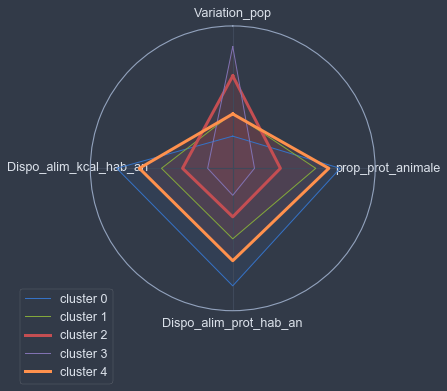

In [47]:
from math import pi
 
# number of variable
categories=list(df_centroids_norma)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(-2,2)
  
# Ind1
values=df_centroids_norma.loc[0].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 0")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df_centroids_norma.loc[2].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 1")
ax.fill(angles, values, 'r', alpha=0.1)

#Ind 1
values=df_centroids_norma.loc[1].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=3, linestyle='solid', label="cluster 2")
ax.fill(angles, values, 'r', alpha=0.1)
 
#Ind 3
values=df_centroids_norma.loc[3].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="cluster 3")
ax.fill(angles, values, 'r', alpha=0.1)

#Ind 4
values=df_centroids_norma.loc[4].drop('index').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=3, linestyle='solid', label="cluster 4")
ax.fill(angles, values, 'r', alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
#plt.suptitle("Radar Chart des clusters selon les variables")
plt.tight_layout()
plt.savefig("Radar Chart des clusters selon les variables")
plt.show()


__Caractérisation des clusters avec rajout d'autres variables__

In [48]:
#rajout de données
dfsécu_alim=pd.read_csv('FAOSTAT_sécurité_alim.csv')
dfréserve_poulet=pd.read_csv('FAOSTAT_réserve_poulet.csv')
dfIDE=pd.read_csv('FAOSTAT_IDE.csv')

#en 2013
dfsécu_alim_piv=dfsécu_alim[['Zone','Produit','Valeur']].pivot_table(index=['Zone'],
                                                                     columns=['Produit'],
                                                                     values=['Valeur'],
                                                                     aggfunc=sum)
dfsécu_alim_piv.columns=['PIB par habitant, ($ PPA internationaux constants de 2011)',
                         'Stabilité politique et absence de violence/terrorisme (indice)']
dfsécu_alim_piv=dfsécu_alim_piv.reset_index()
dfsécu_alim_piv.columns=['Pays','PIB par habitant, ($ PPA internationaux constants de 2011)',
                         'Stabilité politique et absence de violence/terrorisme (indice)']

dfréserve_poulet=dfréserve_poulet[['Zone','Valeur']]
dfréserve_poulet.columns=['Pays','Réserve de poulet en milliers de têtes']

dfIDE=dfIDE[['Zone','Valeur']]
dfIDE.columns=['Pays','L’investissement Direct étranger (millions $ US)']

dfALL=pd.merge(pd.merge(pd.merge(df,dfsécu_alim_piv,on='Pays',how='left'),
                  dfréserve_poulet,on='Pays',how='left'),
         dfIDE,on='Pays',how='left')


#récupération des tableaux pour chaque cluster
df_clusters_CAH2=pd.merge(df_clusters_CAH[df_clusters_CAH.index==2],
                          dfALL,on='Pays',how='left')
df_clusters_CAH2.set_index('Pays',inplace=True)
df_clusters_CAH4=pd.merge(df_clusters_CAH[df_clusters_CAH.index==4],
                          dfALL,on='Pays',how='left')
df_clusters_CAH4.set_index('Pays',inplace=True)

df_clusters_CAH3=pd.merge(df_clusters_CAH[df_clusters_CAH.index==3],
                          dfALL,on='Pays',how='left')
df_clusters_CAH3.set_index('Pays',inplace=True)

dfALL.set_index('Pays',inplace=True)
dfALL.head().to_csv("dfAll.csv")
dfALL.head(3)


,Variation_pop,prop_prot_animale,Dispo_alim_prot_hab_an,Dispo_alim_kcal_hab_an,"PIB par habitant, ($ PPA internationaux constants de 2011)",Stabilité politique et absence de violence/terrorisme (indice),Réserve de poulet en milliers de têtes,L’investissement Direct étranger (millions $ US)
Pays,,,,,,,,
Afghanistan,2.437552,0.209785,21261.25,762850.0,1848.7,-2.52,12053.0,37.64
Afrique du Sud,0.744474,0.426345,31145.45,1103030.0,12339.7,-0.05,161600.0,8300.10
Albanie,0.347881,0.533297,40668.30,1165445.0,10492.8,0.09,8928.0,1265.55


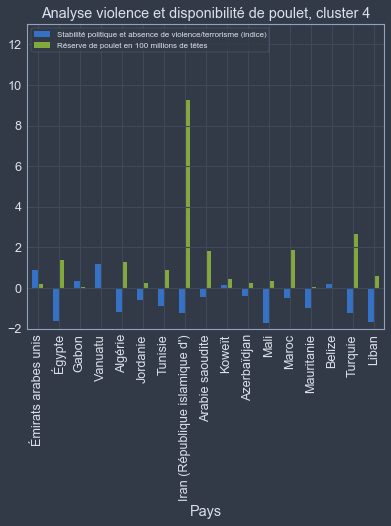

In [49]:
df_clusters_CAH4["Réserve de poulet en 100 millions de têtes"]=df_clusters_CAH4["Réserve de poulet en milliers de têtes"]/100000
df_clusters_CAH4[['Stabilité politique et absence de violence/terrorisme (indice)',
                  "Réserve de poulet en 100 millions de têtes"]].plot(kind='bar',
                                                                     ylim=(-2,13))

plt.legend(loc=2, prop={'size': 8})
plt.title("Analyse violence et disponibilité de poulet, cluster 4")
plt.show()

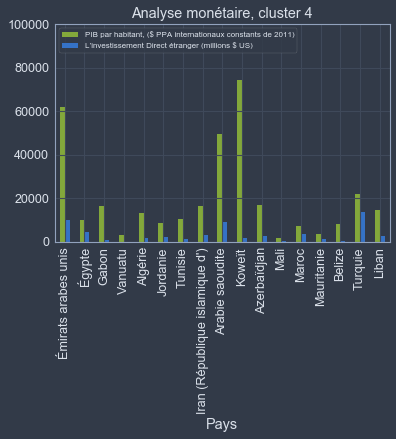

In [50]:
df_clusters_CAH4[['PIB par habitant, ($ PPA internationaux constants de 2011)',
                  "L’investissement Direct étranger (millions $ US)"]].plot(kind='bar',
                                                                            figsize=(6,4),
                                                                            ylim=(0,100000)
                                                                           ,color=['g','b'])
plt.legend(loc=2, prop={'size': 8})
plt.title("Analyse monétaire, cluster 4")
plt.show()

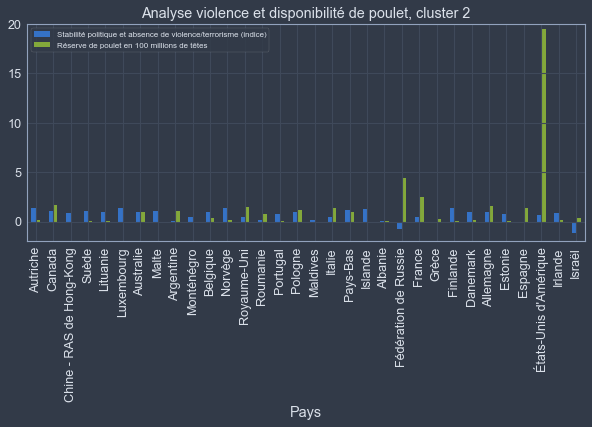

In [51]:
df_clusters_CAH2["Réserve de poulet en 100 millions de têtes"]=df_clusters_CAH2["Réserve de poulet en milliers de têtes"]/100000
df_clusters_CAH2[['Stabilité politique et absence de violence/terrorisme (indice)',
                  "Réserve de poulet en 100 millions de têtes"]].plot(kind='bar',
                                                                     ylim=(-2,20),
                                                                     figsize=(10,4))

plt.legend(loc=2, prop={'size': 8})
plt.title("Analyse violence et disponibilité de poulet, cluster 2")
plt.savefig('Analyse violence et disponibilité de poulet, cluster 2')
plt.show()

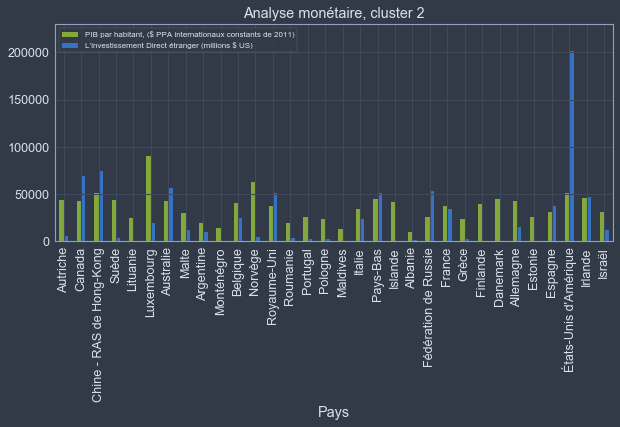

In [52]:
df_clusters_CAH2[['PIB par habitant, ($ PPA internationaux constants de 2011)',
                  "L’investissement Direct étranger (millions $ US)"]].plot(kind='bar',
                                                                            figsize=(10,4),
                                                                            ylim=(0,230000),
                                                                           color=['g','b'])
plt.legend(loc=2, prop={'size': 8})
plt.title("Analyse monétaire, cluster 2")
plt.show()

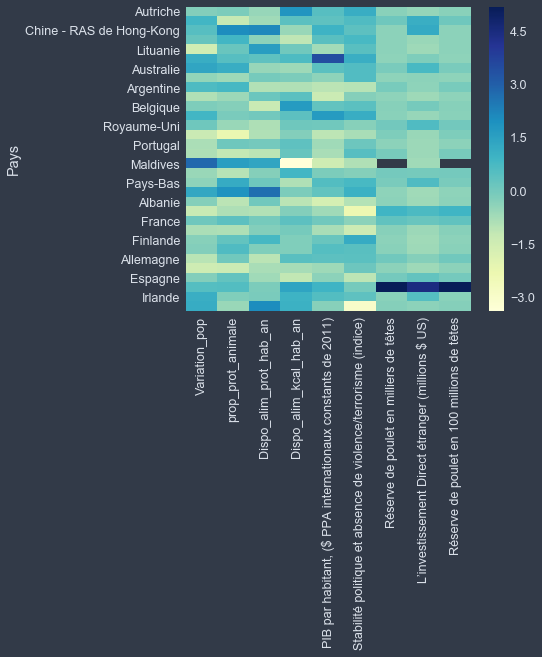

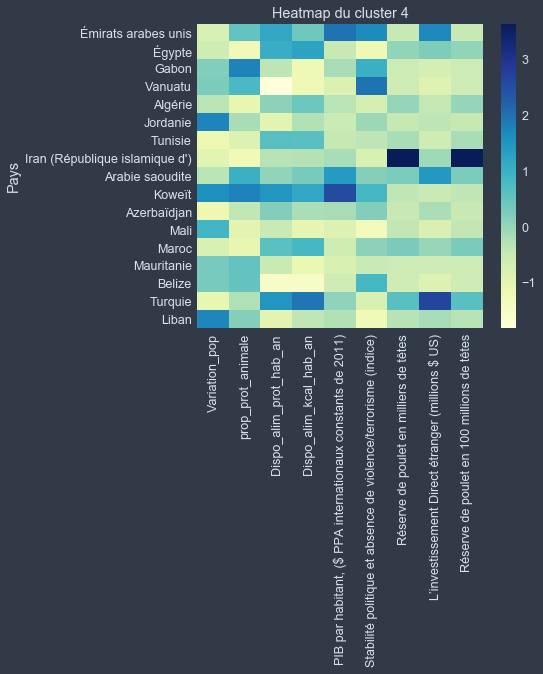

In [53]:
#données normalisées
sns.heatmap((df_clusters_CAH2-df_clusters_CAH2.mean())/df_clusters_CAH2.std(),cmap="YlGnBu")
plt.show()

sns.heatmap((df_clusters_CAH4-df_clusters_CAH4.mean())/df_clusters_CAH4.std(),cmap="YlGnBu")
plt.title("Heatmap du cluster 4")
plt.show()

### Test statistiques

___Test de normalité___

xbar= 17849.82
S'= 19337.36


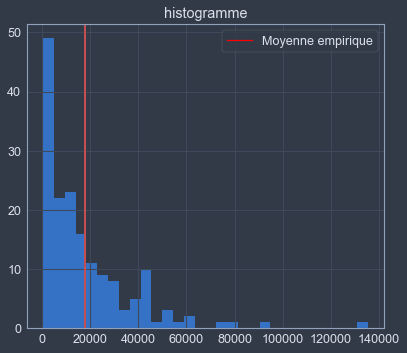

In [54]:
import matplotlib.lines as mlines
import matplotlib.mlab as mlab

xbar=np.mean(dfALL['PIB par habitant, ($ PPA internationaux constants de 2011)'])
print('xbar=',round(xbar,2))
sprime = np.std(dfALL['PIB par habitant, ($ PPA internationaux constants de 2011)'], ddof=1)
print("S'=",round(sprime,2))

#on fait apparaître la moyenne empirique
plt.axvline(xbar, color='r', linewidth=2)
plt.legend(handles=[mlines.Line2D([],[], color='red',markersize=15, label="Moyenne empirique")])

dfALL['PIB par habitant, ($ PPA internationaux constants de 2011)'].hist(bins=30)
plt.title("histogramme")
plt.show()

xbar= 29698.73
S'= 7296.22


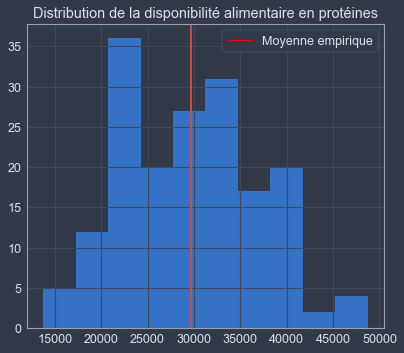

In [55]:
import matplotlib.lines as mlines
import matplotlib.mlab as mlab

xbar=np.mean(df['Dispo_alim_prot_hab_an'])
print('xbar=',round(xbar,2))
sprime = np.std(df['Dispo_alim_prot_hab_an'], ddof=1)
print("S'=",round(sprime,2))

#on fait apparaître la moyenne empirique
plt.axvline(xbar, color='r', linewidth=2)
plt.legend(handles=[mlines.Line2D([],[], color='red',markersize=15, label="Moyenne empirique")])

df['Dispo_alim_prot_hab_an'].hist()
plt.title("Distribution de la disponibilité alimentaire en protéines")
plt.savefig("Distribution de la disponibilité alimentaire en protéines")
plt.show()

$$Ho: F=Fo$$
$$Ho: F \neq Fo$$

Procédons à un test de Kolmogorov-Smirnov sur la variable "Dispo_alim_prot_hab_an" pour tester sa normalité. 
P-value=16%--> On ne peut donc pas rejetter l’hypothèse de normalité (la variable dispo_alim suit une loi normale) au niveau de test 5%.
Le test Shapiro-Wilk n'est pas réalisé ici car on est sur un échantillon de taille assez conséquente (>50 individus).

In [61]:
#attention les valeurs changent à chaque exécution

from scipy.stats import ks_2samp

ks_2samp(df['Dispo_alim_prot_hab_an'],list(np.random.normal(xbar,sprime,1000)))

Ks_2sampResult(statistic=0.1135977011494253, pvalue=0.040213892924705556)

Testons sur l'adéquation à une loi normale de nos autres variables.

In [62]:
for i in range(0,8):
    print(20*'-')
    print(dfALL.dtypes.index[i])
    print(ks_2samp(dfALL.iloc[:,i],
                   list(np.random.normal(np.mean(dfALL.iloc[:,i]),
                                         np.std(dfALL.iloc[:,i]), 1000))))

--------------------
Variation_pop
Ks_2sampResult(statistic=0.08845977011494255, pvalue=0.18699974155031354)
--------------------
prop_prot_animale
Ks_2sampResult(statistic=0.1035172413793104, pvalue=0.07800261638092018)
--------------------
Dispo_alim_prot_hab_an
Ks_2sampResult(statistic=0.0735977011494253, pvalue=0.3851950807671838)
--------------------
Dispo_alim_kcal_hab_an
Ks_2sampResult(statistic=0.06663218390804593, pvalue=0.5123026690133213)
--------------------
PIB par habitant, ($ PPA internationaux constants de 2011)
Ks_2sampResult(statistic=0.191, pvalue=3.195796633872505e-05)
--------------------
Stabilité politique et absence de violence/terrorisme (indice)
Ks_2sampResult(statistic=0.08586206896551729, pvalue=0.21438667269834194)
--------------------
Réserve de poulet en milliers de têtes
Ks_2sampResult(statistic=0.396, pvalue=4.8213382009951176e-21)
--------------------
L’investissement Direct étranger (millions $ US)
Ks_2sampResult(statistic=0.34626436781609193, pvalue=

___Test de comparaison de deux populations gaussiennes___

In [63]:
df_cluster2_list=df_clusters_CAH[df_clusters_CAH.index==2]
df_cluster4_list=df_clusters_CAH[df_clusters_CAH.index==4]
df_cluster2=pd.merge(df_cluster2_list,dfALL,how='left',on='Pays')
df_cluster4=pd.merge(df_cluster4_list,dfALL,how='left',on='Pays')

In [64]:
import scipy.stats

scipy.stats.bartlett(df_cluster2["Dispo_alim_prot_hab_an"],
                     df_cluster4["Dispo_alim_prot_hab_an"])

BartlettResult(statistic=2.0576283727473013, pvalue=0.15144571990301658)

La p-valeur valant 0.15, on ne peut pas rejetter l'hypothèse d’égalité des variances au niveau de test 5%. Regardons désormais pour les moyennes.


In [65]:
scipy.stats.ttest_ind(df_cluster2["Dispo_alim_prot_hab_an"],
                     df_cluster4["Dispo_alim_prot_hab_an"],
                      equal_var=True)

Ttest_indResult(statistic=6.8122798551885, pvalue=1.5749757101956046e-08)

On obtient une p-valeur extrèmement faible. On constate donc que l’hypothèse d’égalité des variances des variables de disponibilité alimentaire en protéines est rejetée.

In [66]:
df_cluster3_list=df_clusters_CAH[df_clusters_CAH.index==3]
df_cluster3=pd.merge(df_cluster3_list,dfALL,how='left',on='Pays')

scipy.stats.bartlett(df_cluster2["Dispo_alim_prot_hab_an"],
                     df_cluster3["Dispo_alim_prot_hab_an"])

BartlettResult(statistic=0.2305631728111783, pvalue=0.6311065584316384)

In [67]:
scipy.stats.ttest_ind(df_cluster2["Dispo_alim_prot_hab_an"],
                     df_cluster3["Dispo_alim_prot_hab_an"],
                      equal_var=True)

Ttest_indResult(statistic=14.24544549172627, pvalue=1.6329423885113425e-25)

On remarque que l'hypothèse d'égalité des variances entre les cluster 2 et 3 est rejetée au niveau de test 5%.